# Can a computer learn if we're going to detect gravitational waves?

This episode of "time to get your hands dirty" is about something I studied carefully in the past: gravitational-wave selection effects. 


![](https://www.ligo.caltech.edu/system/news_items/images/53/page/Virgo_aerial_view_01.jpg?1506530275)



All experiments have selection effects. Some sources are easier to detect than others which distorts the population of sources we observe (this crucial in astronomy! Surveys are typically flux limited). In order to decided if a feature in the observed population of objects is telling us something new about reality, we need to understand and model our selection effects (for instance: it would be wrong to say that all stars are close by just because we can't observe those that are very far!). 
 
**The goal here is to machine-learn the LIGO detectability: can we *predict* if a gravitational-wave source will be detected?**  

[This dataset](https://github.com/dgerosa/pdetclassifier/releases/download/v0.2/sample_2e7_design_precessing_higherordermodes_3detectors.h5) contains simulated gravitational-wave signals from merging black holes (careful the file size is >1 GB). You can read this data format with `h5py`.

In particular, each source has the following features:
- `mtot`: the total mass of the binary
- `q`: the mass ratio
- `chi1x`, `chi1y`, `chi1z`, `chi2x`, `chi2y`, `chi2z`: the components of the black-hole spins in a suitable reference frame.
- `ra`, `dec`: the location of the source in the sky
- `iota`: the inclination of the orbital plane'
- `psi`: the polarization angle (gravitational waves have two polarization states much like light)
- `z`: the redshift

The detectability is defined using the `snr` (signal-to-noise ratio) computed with a state-of-the-art model of the LIGO/Virgo detector network. Some (many?) of you will have studied this in Sesana's gravitational-wave course; [see here](https://arxiv.org/abs/1908.11170) for a nice write-up. All you need to know now is that we threshold the `snr` values and assume that LIGO will (not) see a source if `snr`>12 (`snr`<12). The resulting 0-1 labels are reported in the `det` attribute in the dataset.

Today's task is to train a classifier (you decide which one!) and separate sources that are detectables from those that aren't. 

Be creative! This is a challenge! Let's see who gets the  higher completeness and/or the smaller contamination (on a validation set, of course! Careful with overfitting here!).

*Tips*:
- You can downsample the data for debugging purposes
- You can also use only some of the features. By experience, the most important ones are those involving masses and redshift.


## Another idea

Here are other ideas that I haven't explored in a paper (yet?). 

- Using the same data, we could run a regressor on `snr` instead of a classifier on `det`. We can then threshold the predictions (instead of tresholding the data like we're doing now). Would this give a better performance?

- How about trying to reduce the dimensionality of the dataset with a PCA-type algorithm to ease the classification problem?

Please let me know if you give it a try and what you find! 





In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from astroML.classification import GMMBayes
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import datasets
import matplotlib.pyplot as plt
import h5py
from astroML.utils import split_samples
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
import corner 
from sklearn import metrics
from sklearn.metrics import roc_curve
from astroML.utils import split_samples, completeness_contamination
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap

In [4]:
plt.style.use('ggplot')


f = h5py.File("C:/Users/PC/Desktop/UNI/MAGISTRALE/Astrostatistics/sample_2e7_design_precessing_higherordermodes_3detectors.h5", 'r')
print(list(f.keys()))



['chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z', 'dec', 'det', 'iota', 'mtot', 'psi', 'q', 'ra', 'snr', 'z']


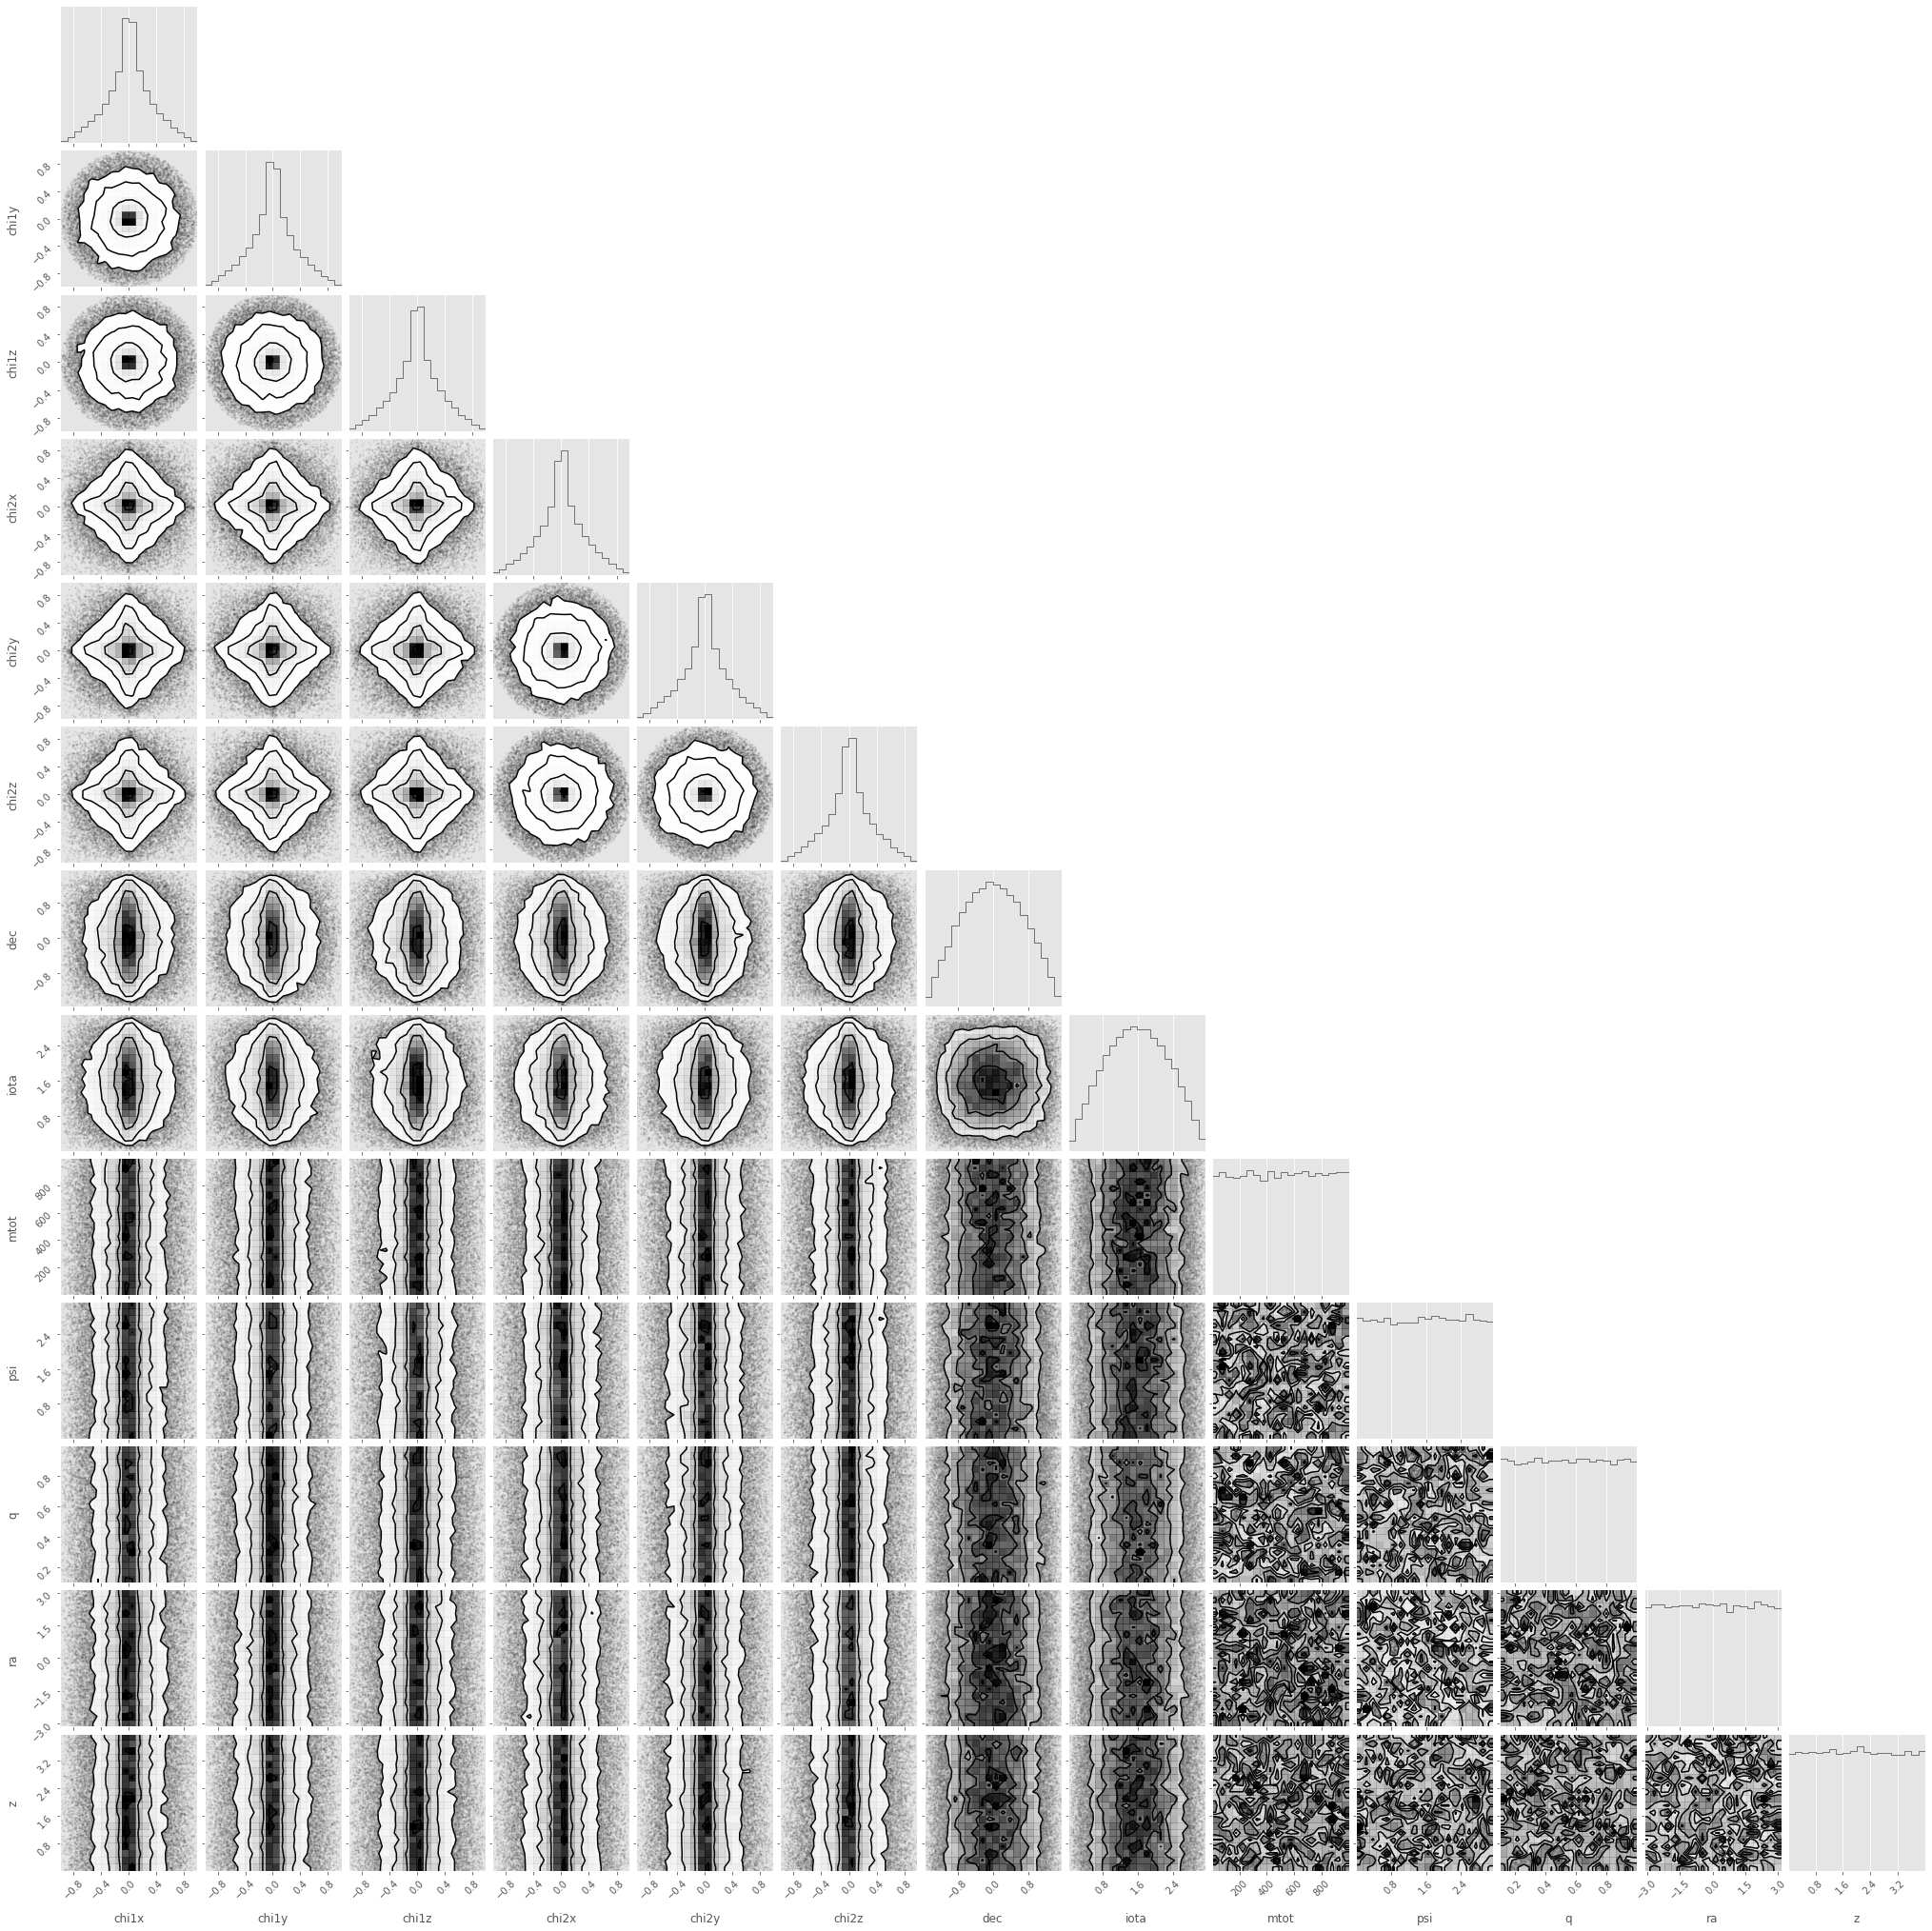

In [5]:
lim=50000
l=[]
for name in (['chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z', 'dec', 'iota', 'mtot', 'psi', 'q', 'ra', 'z']):
    l.append(f[name][:lim])

X=np.array(l).T
index = np.isfinite(X)
X[index==False]=np.mean([X[(index==False)+1],X[(index==False)-1]])
y=f['det'][:lim]

fig=corner.corner(X,labels=['chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z', 'dec', 'iota', 'mtot', 'psi', 'q', 'ra', 'z'])


After had prepared data for machine learning with sklearn. I use the following functio to determine which is the best classifier (both discriminative or gnerative) in my case. The ranking is based on the accuracy of the prediction. From the classification result i decide to choose decisiontree algorithm

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

  0%|          | 0/6 [00:00<?, ?it/s]/Users/federicoastori/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/federicoastori/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.o

LR: 0.940057 (0.003222)


 33%|███▎      | 2/6 [00:03<00:06,  1.66s/it]

LDA: 0.938000 (0.003409)


 50%|█████     | 3/6 [00:06<00:06,  2.09s/it]

KNN: 0.881743 (0.005205)


 67%|██████▋   | 4/6 [00:11<00:06,  3.39s/it]

CART: 0.946486 (0.002945)


 83%|████████▎ | 5/6 [00:11<00:02,  2.24s/it]

NB: 0.935743 (0.003360)


100%|██████████| 6/6 [07:34<00:00, 75.76s/it] 

SVM: 0.856629 (0.005139)


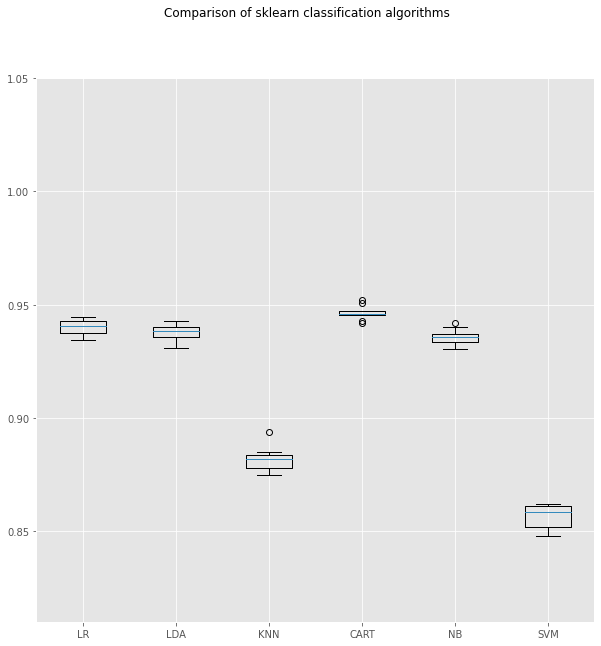

In [5]:


kfold = model_selection.KFold(n_splits=10, random_state=None)

models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

results = []
names = []
scoring = 'accuracy'
for name, model in tqdm(models):
     kfold = model_selection.KFold(n_splits=10, random_state=None)
     cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
     results.append(cv_results)
     names.append(name)
     msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
     print(msg)
     
fig = plt.figure(figsize=(10,10))
fig.suptitle('Comparison of sklearn classification algorithms')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.ylim(0.81,1.05)
plt.show()


Analagously I can use ROC curve to compare the models

GaussianNB
LinearDiscriminantAnalysis
QuadraticDiscriminantAnalysis
LogisticRegression


/Users/federicoastori/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


KNeighborsClassifier
DecisionTreeClassifier
GMMBayes


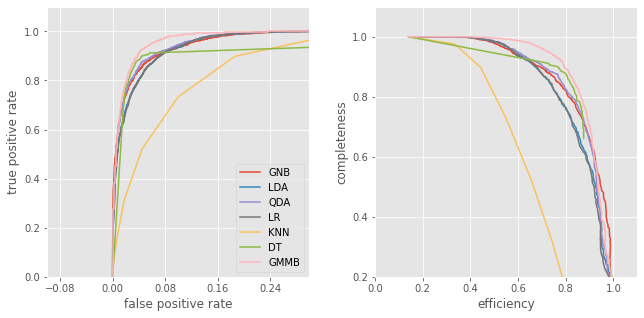

In [6]:
# Fit all the models to the training data
def compute_models(*args):
    names = []
    probs = []
    for classifier, kwargs in args:
        print(classifier.__name__)
        clf = classifier(**kwargs)
        clf.fit(X_train, y_train)
        
        #Note that we are outputing the probabilities [of class 1], not the classes
        y_probs = clf.predict_proba(X_test)[:, 1]

        names.append(classifier.__name__)
        probs.append(y_probs)

    return names, probs


names, probs = compute_models((GaussianNB, {}),
                              (LinearDiscriminantAnalysis, {}),
                              (QuadraticDiscriminantAnalysis, {}),
                              (LogisticRegression,
                               dict(class_weight='balanced')),
                              (KNeighborsClassifier,
                               dict(n_neighbors=10)),
                              (DecisionTreeClassifier,
                               dict(random_state=0, max_depth=12,
                                    criterion='entropy')),
                              (GMMBayes, dict(n_components=3, tol=1E-5,
                                              covariance_type='full')))

#------------------------------------------------------------
# Plot ROC curves and completeness/efficiency
fig = plt.figure(figsize=(15, 5))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15, top=0.9, wspace=0.25)

# ax1 will show roc curves
ax1 = plt.subplot(131)

# ax2 will show completeness/efficiency
ax2 = plt.subplot(132)

# ax3 will show precision/recall
# ax3 = plt.subplot(133)

labels = dict(GaussianNB='GNB',
              LinearDiscriminantAnalysis='LDA',
              QuadraticDiscriminantAnalysis='QDA',
              KNeighborsClassifier='KNN',
              DecisionTreeClassifier='DT',
              GMMBayes='GMMB',
              LogisticRegression='LR')

thresholds = np.linspace(0, 1, 1001)[:-1]

# iterate through and show results
for name, y_prob in zip(names, probs):
    fpr, tpr, thresh = roc_curve(y_test, y_prob)
    precision, recall, thresh2 = precision_recall_curve(y_test, y_prob)

    # add (0, 0) as first point
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])
    # Here we add (1,0) 
    precision = np.concatenate([[0], precision])
    recall = np.concatenate([[1], recall])
    thresh2 = np.concatenate([[0], thresh2])

    ax1.plot(fpr, tpr, label=labels[name])

    #See note above about astroML vs. sklearn
    #Note that the range of threshhold values here is 0% to 100% (0.0 to 1.0)
    comp = np.zeros_like(thresholds)
    cont = np.zeros_like(thresholds)
    for i, t in enumerate(thresholds):
        y_pred = (y_prob >= t)
        comp[i], cont[i] = completeness_contamination(y_pred, y_test)
    ax2.plot(1 - cont, comp, label=labels[name])
    
    #ax3.plot(precision, recall, label=labels[name])

ax1.set_xlim(-0.1, 0.3)
ax1.set_ylim(0, 1.1)
ax1.xaxis.set_major_locator(plt.MaxNLocator(5))
ax1.set_xlabel('false positive rate')
ax1.set_ylabel('true positive rate')
ax1.legend(loc=4)

ax2.set_xlabel('efficiency')
ax2.set_ylabel('completeness')
ax2.set_xlim(0, 1.1)
ax2.set_ylim(0.2, 1.1)

#ax3.set_xlabel('precision')
#ax3.set_ylabel('recall')
#ax3.set_xlim(0, 1.0)
#ax3.set_ylim(0.2, 1.02)

plt.show()

Once I decide to us RandomForest i have to fix the max_depth. I use the ROC curve to understand the maximal depth of my tree. And I use entropy method for the splitting criteria, instead of gini.

100%|██████████| 10/10 [01:54<00:00, 11.43s/it]


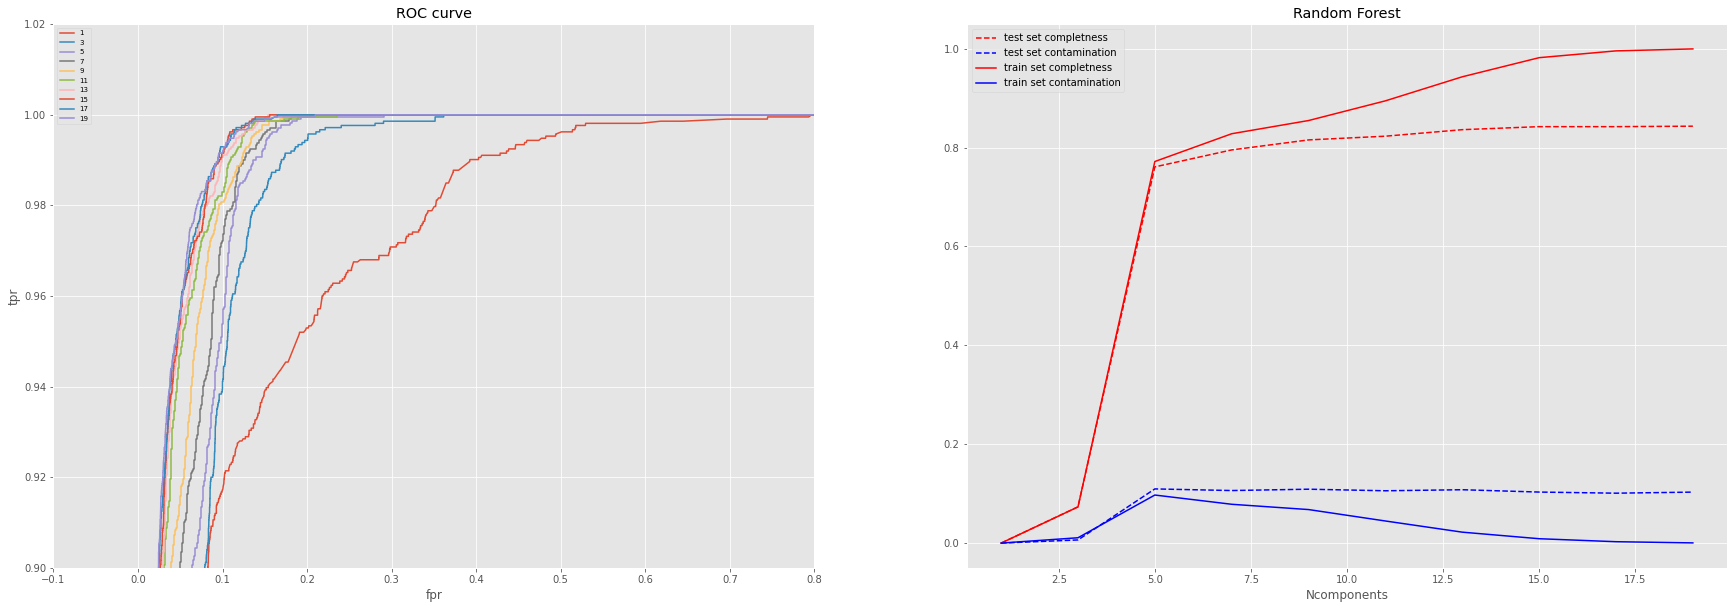

In [7]:
predictions_train=[]
predictions_test=[]
fp=[]
tp=[]

Ncomponents=np.arange(1,20,2)

completeness_test = np.empty((len(Ncomponents)))
contamination_test = np.empty((len(Ncomponents)))
completeness_train = np.empty((len(Ncomponents)))
contamination_train = np.empty((len(Ncomponents)))

i=0

plt.figure(figsize=(30,10))
for nc in tqdm(Ncomponents):
    
    clf = RandomForestClassifier(n_estimators=100, max_depth=nc, random_state=42, criterion='entropy')
    clf.fit(X_train,y_train)
    y_pred_test = clf.predict(X_test) #[:,:6]
    y_pred_train = clf.predict(X_train)
    
    y_prob_test = clf.predict_proba(X_test)[:,1]
    y_prob_train = clf.predict_proba(X_test)[:,1]
    
    fpr, tpr, thresholds = roc_curve(y_test, y_prob_test, pos_label=1)
    
    
    predictions_test.append(y_pred_test)
    predictions_train.append(y_pred_train)
    
    plt.subplot(121)
    plt.plot(fpr,tpr,label='%1.0f' %(nc))
    plt.xlabel('fpr')
    plt.ylabel('tpr')
    plt.title('ROC curve')
    plt.xlim(-0.1,0.8)
    plt.ylim(0.9,1.02)
    plt.legend(loc=0, fontsize='x-small')

    
    
completeness_test, contamination_test = completeness_contamination(predictions_test, y_test)
completeness_train, contamination_train = completeness_contamination(predictions_train, y_train)

    
plt.subplot(122)
plt.title('Random Forest')
plt.plot(Ncomponents,completeness_test,'--r', label='test set completness')
plt.plot(Ncomponents,contamination_test,'--b',label='test set contamination')
plt.plot(Ncomponents,completeness_train,'-r', label='train set completness')
plt.plot(Ncomponents,contamination_train,'-b',label='train set contamination')
plt.xlabel('Ncomponents')
plt.legend(loc=0)

Since the previous test is not conclusive let me use gridsearcCV to make cross validation and determine the optimal max depth

In [8]:
clf = RandomForestClassifier()
drange = np.arange(1,5)  #Complete
#erange = np.arange(1,100)

grid = GridSearchCV(clf, param_grid={'max_depth': drange}, cv=5) #Complete
grid.fit(X, y)

best = grid.best_params_['max_depth']
print("best parameter choice:", best)
#print(grid.best_params_['n_estimators'])

best parameter choice: 4


Set the maximal depth to "best" I compare prediction with the truth result and I compute the confusion matrix to check the classification correctness in a more quantitative way.


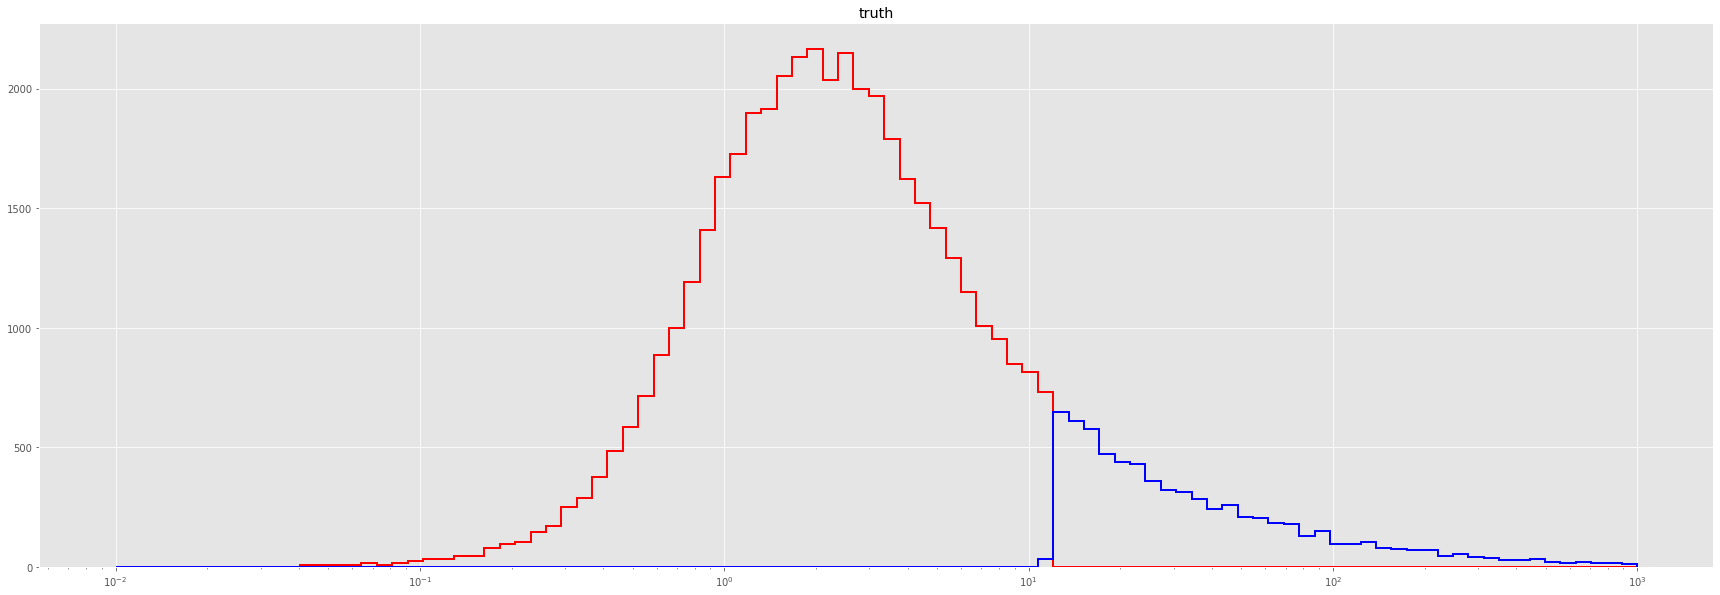

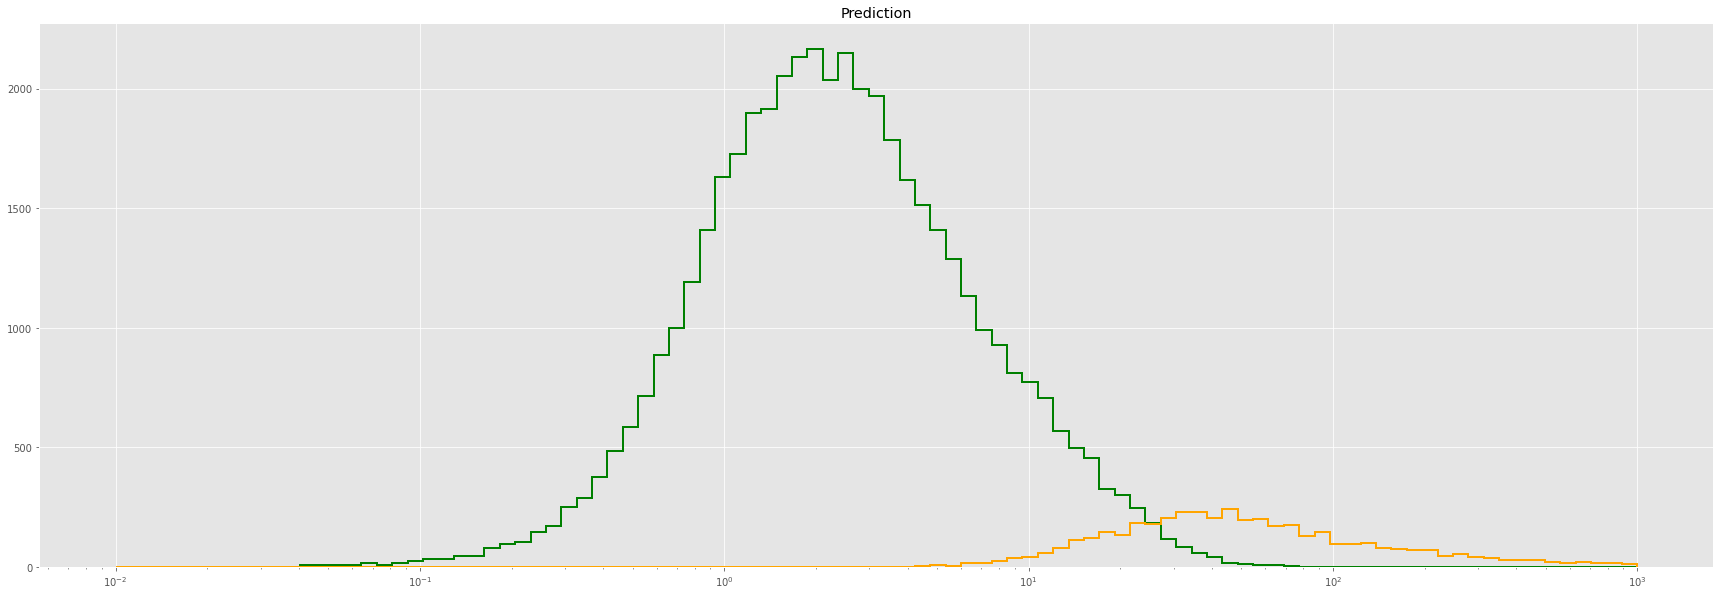

In [9]:
clf = RandomForestClassifier(max_depth=best, random_state=0, criterion='entropy')
clf.fit(X_train,y_train)
y_pred1 = clf.predict(X)

snr=f['snr'][:lim]

plt.figure(figsize=(30,10))
plt.title('truth')
plt.hist(snr[y==0],bins=np.logspace(-2,3,100), histtype='step', color='red', linewidth=2)
plt.hist(snr[y==1], bins=np.logspace(-2,3,100), histtype='step', color='blue', linewidth=2)
plt.xscale('log')

plt.figure(figsize=(30,10))
plt.title('Prediction')
plt.hist(snr[y_pred1==0],bins=np.logspace(-2,3,100), histtype='step', color='green', linewidth=2)
plt.hist(snr[y_pred1==1], bins=np.logspace(-2,3,100), histtype='step', color='orange', linewidth=2)
plt.xscale('log')


Fraction of right detection 3.1203333333333334


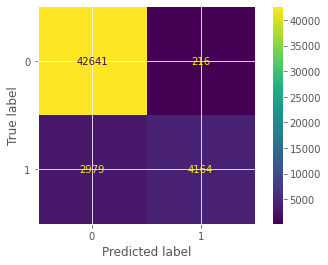

In [10]:
C = confusion_matrix(y, y_pred1)
cm_display_train = metrics.ConfusionMatrixDisplay(confusion_matrix = C)
cm_display_train.plot() 

print('Fraction of right detection', np.sum(C.diagonal())/len(y_test))

In [11]:
clf = DecisionTreeClassifier( max_depth=7)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
C = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = C.ravel()
print("completeness test", tp/(tp+fn))
print("contamination test", fp/(tp+fp))

y_pred = clf.predict(X_train)
C = confusion_matrix(y_train, y_pred)
tn, fp, fn, tp = C.ravel()
print("completeness train", tp/(tp+fn))
print("contamination train", fp/(tp+fp))

completeness test 0.8047058823529412
contamination test 0.1432865731462926
completeness train 0.8417696293343961
contamination train 0.10998735777496839


In [12]:
clf = GaussianNB()

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
C = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = C.ravel()
print("completeness test", tp/(tp+fn))
print("contamination test", fp/(tp+fp))

y_pred = clf.predict(X_train)
C = confusion_matrix(y_train, y_pred)
tn, fp, fn, tp = C.ravel()
print("completeness train", tp/(tp+fn))
print("contamination train", fp/(tp+fp))

completeness test 0.8832941176470588
contamination test 0.2802914110429448
completeness train 0.8802311677959347
contamination train 0.27124236924599904


In [11]:
# let me try to reduce the dimensions with a PCA like algorithm and try to improve the classification
sc = StandardScaler()
  
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

pca = PCA(n_components = 2)
  
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
  
explained_variance = pca.explained_variance_ratio_


rfc = RandomForestClassifier(max_depth=3, random_state=0, criterion='entropy')
rfc.fit(X_train,y_train)

y_pred_red = rfc.predict(X_test)


cm = confusion_matrix(y_test, y_pred_red)
#tn, fp, fn, tp = cm.ravel()
#print("completeness test", tp/(tp+fn))
#print("contamination test", fp/(tp+fp))


print(cm)

completeness test 0.0
contamination test nan
[[12803     0]
 [ 2197     0]]


<ipython-input-11-ab84998d31d8>:24: RuntimeWarning: invalid value encountered in longlong_scalars
  print("contamination test", fp/(tp+fp))


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


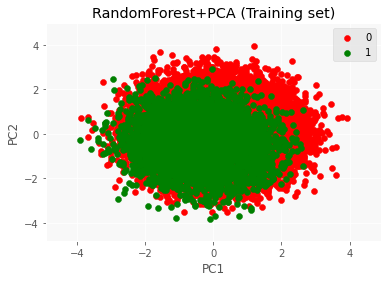

In [15]:

X_set, y_set = X_train, y_train
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1,
                     stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1,
                     stop = X_set[:, 1].max() + 1, step = 0.01))
  
plt.contourf(X1, X2, rfc.predict(np.array([X1.ravel(),
             X2.ravel()]).T).reshape(X1.shape), alpha = 0.75,
             cmap = ListedColormap(('white', 'yellow', 'aquamarine')))
  
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
  
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green', 'blue'))(i), label = j)
  
plt.title('RandomForest+PCA (Training set)')
plt.xlabel('PC1') # for Xlabel
plt.ylabel('PC2') # for Ylabel
plt.legend() # to show legend
  
# show scatter plot
plt.show()


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


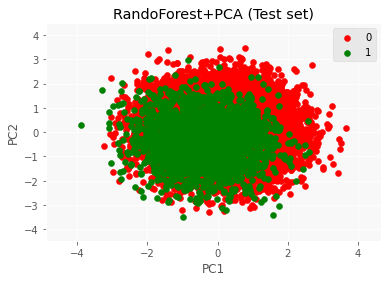

In [14]:
X_set, y_set = X_test, y_test
  
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1,
                     stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1,
                     stop = X_set[:, 1].max() + 1, step = 0.01))
  
plt.contourf(X1, X2, rfc.predict(np.array([X1.ravel(),
             X2.ravel()]).T).reshape(X1.shape), alpha = 0.75,
             cmap = ListedColormap(('white','yellow', 'aquamarine'))) 
  
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
  
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green', 'blue'))(i), label = j)
  
# title for scatter plot
plt.title('RandoForest+PCA (Test set)') 
plt.xlabel('PC1') # for Xlabel
plt.ylabel('PC2') # for Ylabel
plt.legend()
  
# show scatter plot
plt.show()